In [290]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy.spatial import distance_matrix
from scipy import interpolate
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import emcee
from scipy.stats import uniform
from emcee.moves import WalkMove,DEMove
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D


# To DO
## Weekend work
- Must first fix my KDE implementation so that my peaked parameters are consistent with my plots
- After MCMCing. I now have a distribution for all my parameters. I need to:
- plot using the mean parameters
- plot using the peaked parameters
- plot cross sections for each of these. On the same graph so that I can compare
- from my kernel selection worksheet pick optimal values for my each of my kernels and run this for each kernel 

So have 5 kernels do this 5 times.


## Monday to Wednesday
# After this 
I must get my mathematical theory sound 

In [291]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)


X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
#E_train = np.concatenate((E1_train.reshape(-1,1),E2_train.reshape(-1,1),E3_train.reshape(-1,1),E4_train.reshape(-1,1)))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))



In [311]:
def log_prior(theta):
    return np.sum(uniform(loc=0.01, scale=4.99).logpdf(theta))

In [312]:
def log_posterior(theta,gpr):
    ### get rid before putting through log
    if np.any(theta <= 0): 
        return -np.inf

    theta = np.log(theta)  

    if not np.isfinite(theta).all():  
        return -np.inf

    real_theta = np.exp(theta)
    lp = log_prior(real_theta)  

    if not np.isfinite(lp):
        return -np.inf

    ll = gpr.log_marginal_likelihood(theta)


    if not np.isfinite(ll):  
        return -np.inf

    return lp + ll

In [ ]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
bounds_lsingle = (1e-4, 10.0)  
guess_lsingle = 1.0
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
nu = 1.75
alpha = 1
periodicity = np.linspace(0.1, 3, 10)[7]
gamma = 1


Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu)
Radkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RationalQuadratic(length_scale=guess_lsingle, alpha=alpha, length_scale_bounds=bounds_lsingle)
ExpSinekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * ExpSineSquared(length_scale=guess_lsingle, periodicity=periodicity, length_scale_bounds=bounds_lsingle)
Laplacekernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * PairwiseKernel(gamma=gamma, metric='laplacian')
RBFkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_lmult, length_scale_bounds=bounds_lmult)

kernel_list = [Matkernel, Radkernel, ExpSinekernel, Laplacekernel, RBFkernel]
kernel_names = ['Matern', 'Rational Quadratic', 'ExpSineSquared', 'Laplacian', 'RBF']
dimensions = [5,3,3,2,5]
dimensionnames = [['sigma','l1','l2','l3','l4'],['sigma','alpha','l'],['sigma','l','periodicity'],['sigma','gamma'],['sigma','l1','l2','l3','l4']]
parammult = [[1,2,2,2],[0.5,1,0.5],[0.1,0.1,1],[1,1],[1,2,2,2]]
DEmovegamma = [0.3,None,None,None,0.3]

In [370]:
### i dictates the kernel we use. I could put this in a complete loop. Loop takes ages to run so doing one at a time
kernelindex = 3
gpr = GaussianProcessRegressor(kernel=kernel_list[kernelindex], alpha=E_train**2,normalize_y=True, n_restarts_optimizer=30,random_state=42)
gpr.fit(X_train, D_train)
Dfit, Dstd = gpr.predict(X1, return_std=True)
print(f"Fitted Kernel: {gpr.kernel_}")
print(np.exp(gpr.kernel_.theta))
params = []
for j in range(dimensions[kernelindex]):
    params.append(np.exp(gpr.kernel_.theta[j]))
print(params)

c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fitted Kernel: 1.12**2 * PairwiseKernel(gamma=0.2502837702930708, metric=laplacian)
[1.25335391 0.25028377]
[1.2533539111996768, 0.2502837702930708]


In [371]:
#### making the samples pulled out reproducible
np.random.seed(42)

ndim = dimensions[kernelindex]
nwalkers = ndim*4 

mean = np.array(params)
diag_factors = [p *mults for p, mults in zip(params, parammult[kernelindex])]
cov_matrix = np.diag(diag_factors)
### Where we start sampling. I take the absolute value here because I want my parameters to be positive
initial_pos = np.abs(np.random.multivariate_normal(mean, cov_matrix, nwalkers))  

### Sampler
####move = DEMove(gamma=0.5)  this is an option to use moves = move to try and increase the acceptance fraction
### try different moves
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args= (gpr,),moves = DEMove(gamma0=DEmovegamma[i]))

### I need to figure out my sampler move issue. Using the above, my acceptance rate is roughly 0.1. Which produces a nicer result but is too small 


## sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,moves=DEMove(gamma0 = 0.5))

### Now using a smaller gamma above results in a larger acceptance rate but not as nice of a result. Well it means that the mean and the peak lines up better

nsteps = 500
samples = sampler.run_mcmc(initial_pos, nsteps, progress = True)

acceptance_fraction = sampler.acceptance_fraction


# burnin = 100 ## Remove 100 at start of every walker
# thin = 15 ## take 1 of every 15 samples
burnin = 100
thin = 15
print(acceptance_fraction.mean())

100%|██████████| 500/500 [01:34<00:00,  5.31it/s]

0.3085


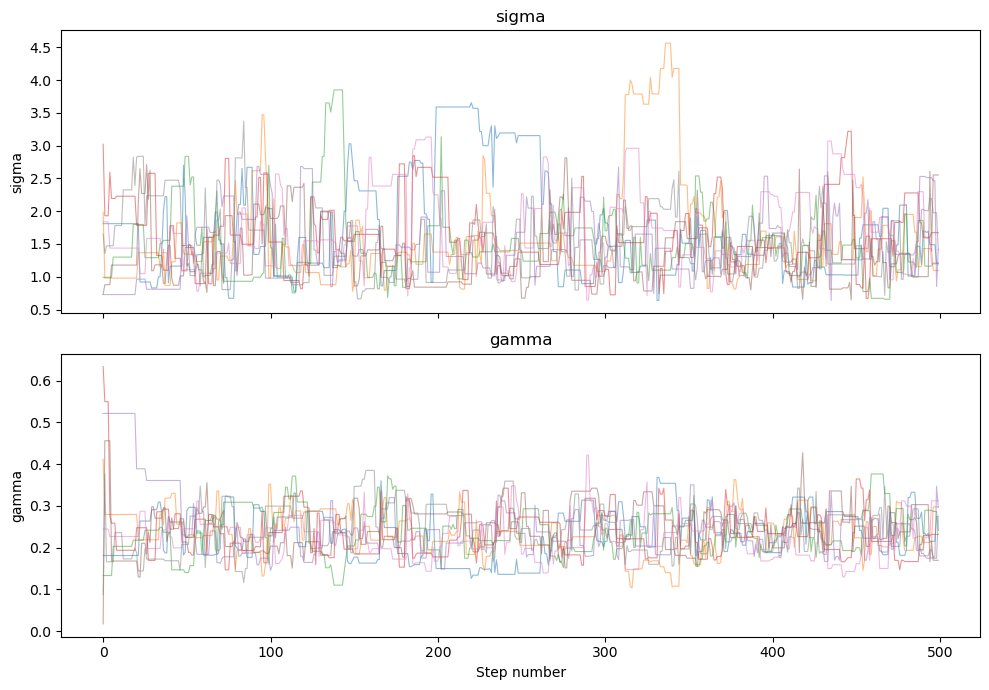

In [372]:
samples1 = sampler.get_chain()

#### This has shape samples walker dimension so can split up based on each walker

parameter_labels = dimensionnames[kernelindex]
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(10, 7))
for i in range(ndim):
    ax = axes[i]
    for walker in range(samples1.shape[1]):  
        ax.plot(samples1[:, walker, i], alpha=0.5, lw=0.8)
    ax.set_ylabel(parameter_labels[i])
    ax.set_title(f"{parameter_labels[i]}")

axes[-1].set_xlabel("Step number")
plt.tight_layout()
plt.show()

In [374]:
peak_values = []
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
for i in range(ndim):
    samples_i = flat_samples[:, i]
    kde = gaussian_kde(samples_i)  

    x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
    density = kde(x_range)
    # plt.figure()
    # plt.plot(x_range, density, 
    #      color='gray', linewidth=2.5)
    peak = x_range[np.argmax(density)]
    peak_values.append(peak)
print("Peak values for each parameter:", peak_values)

Peak values for each parameter: [1.3056164348215482, 0.24517892624393034]


In [375]:
mean_values = np.mean(flat_samples, axis=0)      # shape: (parameter number,)
std_values  = np.std(flat_samples, axis=0)      # same shape as mean_values
ci_bounds   = np.percentile(flat_samples, [2.5, 97.5], axis=0)  # shape: (2, parameter number)

labels = dimensionnames[kernelindex]
for i, label in enumerate(labels):
    # Option 1: Use .item() to extract the scalar
    mean_i = mean_values[i].item()
    std_i  = std_values[i].item()
    lower_ci = ci_bounds[0, i].item()
    upper_ci = ci_bounds[1, i].item()
    print(f"{label}: mean = {mean_i:.4f}, std = {std_i:.4f}, 95% CI = [{lower_ci:.4f}, {upper_ci:.4f}]")

sigma: mean = 1.5563, std = 0.6126, 95% CI = [0.8200, 3.1415]
gamma: mean = 0.2350, std = 0.0491, 95% CI = [0.1439, 0.3410]


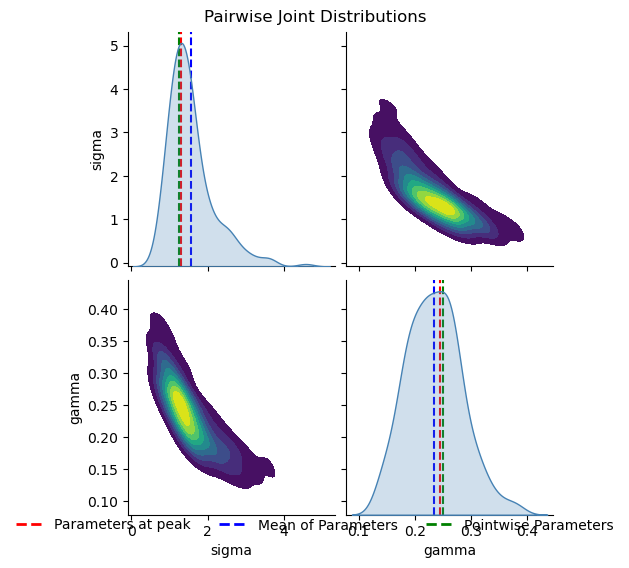

In [376]:

# flat_samples has shape samples dimensions samples dimensions and so combines all walker samples
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
df = pd.DataFrame(flat_samples, columns=dimensionnames[kernelindex])

## a kde plot, plots the estimated probability density function from my MCMC samples 

g = sns.pairplot(    df,
    kind="kde",
    diag_kind="kde",
    plot_kws={'fill': True, 'cmap': 'viridis'},
    diag_kws={'fill': True, 'color': 'steelblue'})
plt.suptitle("Pairwise Joint Distributions", y=1.02)
for i in range(ndim):
        ax = g.axes[i, i]
        ax.axvline(peak_values[i], color="red", linestyle="--")
        ax.axvline(mean_values[i], color="blue", linestyle="--")
        ax.axvline(params[i], color="green", linestyle="--")
legend_elements = [
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Parameters at peak'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean of Parameters'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Pointwise Parameters')
]

# Add the legend to the figure, placing it centered below the plots
g.fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)

# Adjust the figure so the legend is not cut off
g.fig.subplots_adjust(bottom=0.01)

plt.show()

## Marginalising over all the samples (Averaging parameters over all samples)

In [192]:
# Storage for predictions
S = len(flat_samples)
pred_means = np.zeros((S, len(X1)))
pred_vars = np.zeros((S, len(X1)))
pred_testmeans = np.zeros((S, len(X1_test)))

# Iterate over posterior samples of hyperparameters with a progress bar
for s in tqdm(range(S), desc="Running GP Predictions", unit="sample"):
    theta_s = flat_samples[s]  # Get one sample from posterior
    kernel = gpr.kernel_.clone_with_theta(np.log(theta_s))  # Set kernel with sampled hyperparameters
    gp = GaussianProcessRegressor(kernel=kernel,alpha =E_train**2, optimizer= None)  
    gp.fit(X_train, D_train)  # Fit GP with the sampled hyperparameters
    # Predictive mean and variance for X1
    pred_means[s, :], pred_stds = gp.predict(X1, return_std=True)
    pred_vars[s, :] = pred_stds**2  # Convert std deviation to variance
final_mean = np.mean(pred_means, axis=0)
final_variance = np.mean(pred_vars + pred_means**2, axis=0) - final_mean**2
final_std = np.sqrt(final_variance)

Running GP Predictions: 100%|██████████| 520/520 [00:31<00:00, 16.37sample/s]


## GPR on mean parameter values from MCMC

In [379]:
print(mean_values)
sigma = mean_values[0]
l1 = mean_values[1] 
#l2 = mean_values[2]
#l3 = mean_values[3]
#l4 = mean_values[4]
kernel = gpr.kernel_.clone_with_theta(np.log(mean_values))
gpr1 = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2, normalize_y=True,optimizer=None)
gpr1.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr1.kernel_}")
Dfit1, Dstd1 = gpr1.predict(X1, return_std=True)

[1.55625938 0.2349931 ]
Fitted Kernel: 1.25**2 * PairwiseKernel(gamma=0.23499309950482453, metric=laplacian)


## GPR on peaked parameter values from MCMC

In [197]:
sigma = peak_values[0]
l1 = peak_values[1]
l2 = peak_values[2]
l3 = peak_values[3]
l4 = peak_values[4]
kernel = gpr.kernel_.clone_with_theta(np.log([sigma,l1,l2,l3,l4]))
gpr2 = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2, normalize_y=True,optimizer=None)
gpr2.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr2.kernel_}")
Dfit2, Dstd2 = gpr2.predict(X1, return_std=True)
print(peak_values)

Fitted Kernel: 0.839**2 * RBF(length_scale=[0.146, 0.75, 0.833, 2.39])
[0.7041950890988596, 0.14551279108303983, 0.7495415030382635, 0.8325175966586653, 2.3906652516856353]


## Plotting these techniques together.

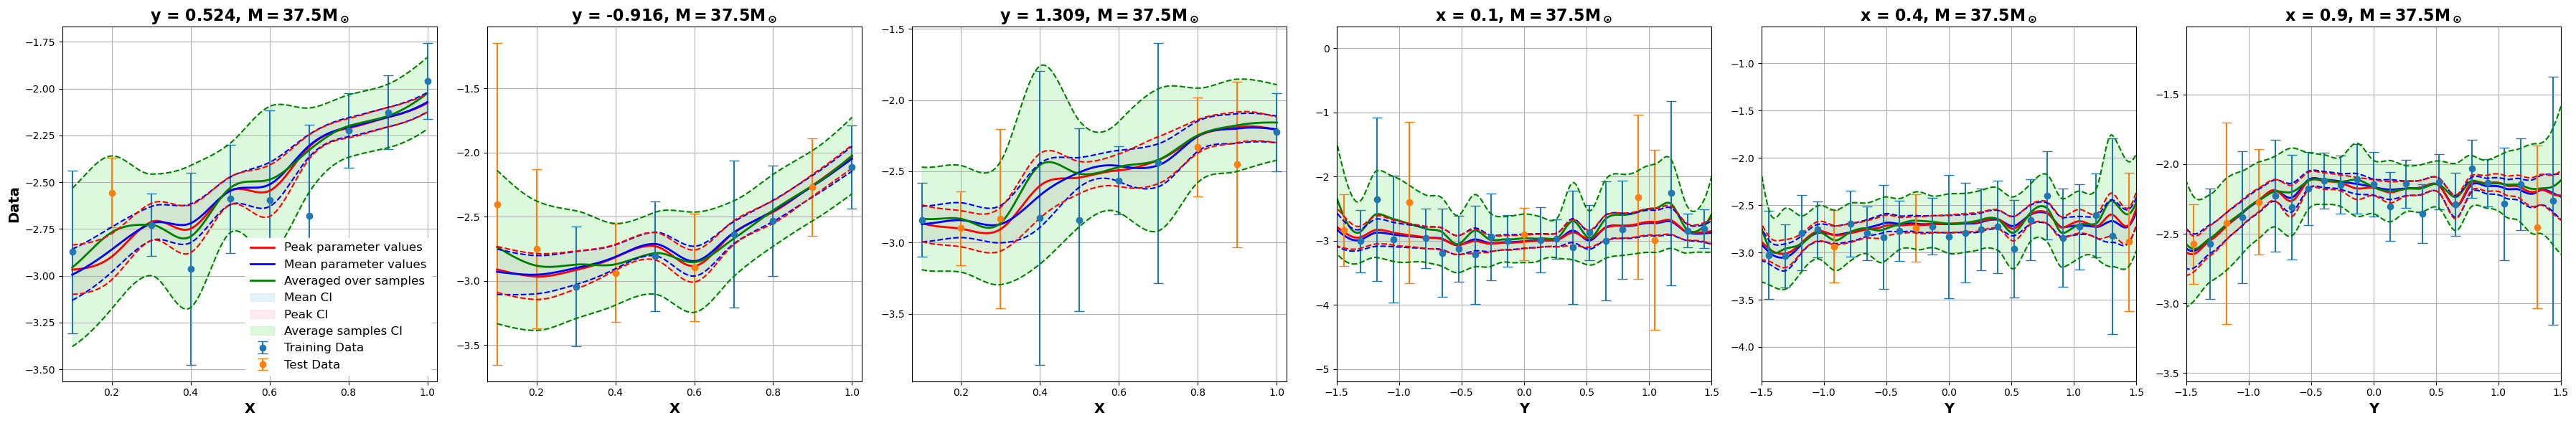

In [198]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
xpoints = np.linspace(0, 1, 1000)
ypoints = [0.5235987755982988,-0.9162978572970231,1.3089969389957472]
ypoints2 = np.linspace(-1.5707963267948966,1.5707963267948966,1000)
xpoints2 = [ 0.1,0.4,0.9]
titles = [
    f"y = {round(ypoints[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"y = {round(ypoints[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[0], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[1], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$",
    f"x = {round(xpoints2[2], 3)}, $\\mathbf{{M = 37.5M_\\odot}}$"
]


fig, axes = plt.subplots(1, 6, figsize=(36, 6), sharey=False)
j = 0
for i, ax in enumerate(axes):
    if (i<=2):
        ypoint = ypoints[i]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoints, ypoint), method="cubic")
        zgridlinear_std = griddata((xm1, ym1),Dstd1, (xpoints, ypoint), method="cubic")
        zgridlinear_mean2 = griddata((xm1, ym1), Dfit2, (xpoints, ypoint), method="cubic")
        zgridlinear_std2 = griddata((xm1, ym1),Dstd2, (xpoints, ypoint), method="cubic")
        zgridlinear_mean3 = griddata((xm1, ym1), final_mean, (xpoints, ypoint), method="cubic")
        zgridlinear_std3 = griddata((xm1, ym1),final_std, (xpoints, ypoint), method="cubic")
        #zgridlinear_mean4 = griddata((xm1, ym1), Dfit, (xpoints, ypoint), method="cubic")
        #zgridlinear_std4 = griddata((xm1, ym1),Dstd, (xpoints, ypoint), method="cubic")
        indices1 = np.isclose(y1train,ypoints[i])
        indices2 = np.isclose(y1test,ypoints[i])
        ax.errorbar(x1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(), fmt='o', capsize=5,label = 'Training Data')
        ax.errorbar(x1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')
        ax.plot(xpoints,zgridlinear_mean2,label='Peak parameter values', color='red', linewidth=2)
        ax.plot(xpoints, zgridlinear_mean,label='Mean parameter values', color='blue', linewidth=2)
        ax.plot(xpoints, zgridlinear_mean3,label='Averaged over samples', color='green', linewidth=2)
        ax.fill_between(xpoints, 
                zgridlinear_mean - 2*zgridlinear_std, 
                zgridlinear_mean + 2*zgridlinear_std, 
                color='lightblue', alpha=0.3, label='Mean CI')
        ax.plot(xpoints, zgridlinear_mean - 2*zgridlinear_std, '--', color='blue', linewidth=1.5)
        ax.plot(xpoints, zgridlinear_mean + 2*zgridlinear_std, '--', color='blue', linewidth=1.5)

        ax.fill_between(xpoints, 
                        zgridlinear_mean2 - 2*zgridlinear_std2, 
                        zgridlinear_mean2 + 2*zgridlinear_std2, 
                        color='pink', alpha=0.3, label='Peak CI')
        ax.plot(xpoints, zgridlinear_mean2 - 2*zgridlinear_std2, '--', color='red', linewidth=1.5)
        ax.plot(xpoints, zgridlinear_mean2 + 2*zgridlinear_std2, '--', color='red', linewidth=1.5)

        ax.fill_between(xpoints, 
                        zgridlinear_mean3 - 2*zgridlinear_std3, 
                        zgridlinear_mean3 + 2*zgridlinear_std3, 
                        color='lightgreen', alpha=0.3, label="Average samples CI")
        ax.plot(xpoints, zgridlinear_mean3 - 2*zgridlinear_std3, '--', color='green', linewidth=1.5)
        ax.plot(xpoints, zgridlinear_mean3 + 2*zgridlinear_std3, '--', color='green', linewidth=1.5)
        
        ax.set_xlim((0.075, 1.025))
        ax.set_xlabel('X', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
    else:
        xpoint = xpoints2[j]
        zgridlinear_mean = griddata((xm1, ym1), Dfit1, (xpoint, ypoints2), method="cubic")
        zgridlinear_std = griddata((xm1, ym1), Dstd1, (xpoint, ypoints2), method="cubic")
        zgridlinear_mean2 = griddata((xm1, ym1), Dfit2, (xpoint, ypoints2), method="cubic")
        zgridlinear_std2 = griddata((xm1, ym1), Dstd2, (xpoint, ypoints2), method="cubic")
        zgridlinear_mean3 = griddata((xm1, ym1), final_mean, (xpoint, ypoints2), method="cubic")
        zgridlinear_std3 = griddata((xm1, ym1), final_std, (xpoint, ypoints2), method="cubic")
        indices1 = np.isclose(x1train,xpoint)
        indices2 = np.isclose(x1test,xpoint)
        ax.plot(ypoints2, zgridlinear_mean, label='Mean parameter values', color='blue', linewidth=2)
        ax.plot(ypoints2, zgridlinear_mean2, label='Peak parameter values', color='red', linewidth=2)
        ax.plot(ypoints2, zgridlinear_mean3, label='Averaged over samples', color='green', linewidth=2)
        ax.errorbar(y1train[indices1].ravel(), D1_train[indices1].ravel(), yerr=E1_train[indices1].ravel(),fmt='o', capsize=5,label = 'Training Data')
        ax.errorbar(y1test[indices2].ravel(),D1_test[indices2].ravel(), yerr=E1_test[indices2].ravel(), fmt='o', capsize=5,label = 'Test Data')   
        ax.fill_between(ypoints2, 
                        zgridlinear_mean - 2*zgridlinear_std, 
                        zgridlinear_mean + 2*zgridlinear_std, 
                        color='lightblue', alpha=0.3, label="Mean CI")
        ax.plot(ypoints2, zgridlinear_mean - 2*zgridlinear_std, '--', color='blue', linewidth=1.5)
        ax.plot(ypoints2, zgridlinear_mean + 2*zgridlinear_std, '--', color='blue', linewidth=1.5)

        ax.fill_between(ypoints2, 
                        zgridlinear_mean2 - 2*zgridlinear_std2, 
                        zgridlinear_mean2 + 2*zgridlinear_std2, 
                        color='pink', alpha=0.3, label="Peak CI")
        ax.plot(ypoints2, zgridlinear_mean2 - 2*zgridlinear_std2, '--', color='red', linewidth=1.5)
        ax.plot(ypoints2, zgridlinear_mean2 + 2*zgridlinear_std2, '--', color='red', linewidth=1.5)

        ax.fill_between(ypoints2, 
                        zgridlinear_mean3 - 2*zgridlinear_std3, 
                        zgridlinear_mean3 + 2*zgridlinear_std3, 
                        color='lightgreen', alpha=0.3, label="Average samples CI")
        ax.plot(ypoints2, zgridlinear_mean3 - 2*zgridlinear_std3, '--', color='green', linewidth=1.5)
        ax.plot(ypoints2, zgridlinear_mean3 + 2*zgridlinear_std3, '--', color='green', linewidth=1.5)
    
        ax.set_xlim((-1.5, 1.5))
        ax.set_xlabel('Y', fontsize=14, weight='bold')
        ax.set_title(titles[i], fontsize=16, weight='bold')
        ax.grid(True)
        j+=1
        
axes[0].set_ylabel('Data', fontsize=14, weight='bold')

legend = axes[0].legend(fontsize=12,loc='lower right',frameon=True)
legend.get_frame().set_facecolor('white')  # Set the background color to grey
legend.get_frame().set_edgecolor('white')  # Optional: Add a black edge to the frame
legend.get_frame().set_alpha(1)  # Optional: Set opacity (1 = solid)
plt.tight_layout()
plt.show()